# 2 - Workflow management with atomate

In this lesson we cover a few more advanced features of the atomate software package.  More specifically we'll go over an example that includes parents and children, talk more about where you can find preset workflows, and cover a basic example of analyzing workflow-generated materials data.

In [1]:
from mp_workshop.atomate import wf_to_graph, use_fake_vasp_workshop
from tqdm import tqdm_notebook

Echo Test: MP Workshop


## Why use atomate?

Just to motivate this lesson a bit more, I'd like to share an example that illustrates the value of atomate.  Let's say you wanted to calculate the bandstructure of every polymorph of SiO$_2$.  Normally, you'd need to get all of the cifs from MP or the ICSD, construct the POSCARs by hand, or use some of your own infrastructure to convert them, run the calculations and manage the directory structure, and aggregate the results in a way that allowed you to analyze them together.  In atomate, this is achieved in a simple, five line snippet:

In [2]:
from atomate.vasp.workflows.presets.core import get_wf
from fireworks import LaunchPad

lpad = LaunchPad.auto_load()
lpad.reset("", require_password=False)

from pymatgen import MPRester
mpr = MPRester()

structures = mpr.get_structures("SiO2")
for structure in tqdm_notebook(structures):
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2018-08-10 05:47:03,269 INFO Performing db tune-up
2018-08-10 05:47:03,277 INFO LaunchPad was RESET.
2018-08-10 05:47:06,553 INFO Added a workflow. id_map: {-1: 4, -4: 1, -3: 2, -2: 3}
2018-08-10 05:47:06,569 INFO Added a workflow. id_map: {-8: 5, -7: 6, -6: 7, -5: 8}
2018-08-10 05:47:06,578 INFO Added a workflow. id_map: {-12: 9, -11: 10, -10: 11, -9: 12}
2018-08-10 05:47:06,595 INFO Added a workflow. id_map: {-16: 13, -15: 14, -14: 15, -13: 16}
2018-08-10 05:47:06,661 INFO Added a workflow. id_map: {-20: 17, -19: 18, -18: 19, -17: 20}
2018-08-10 05:47:06,702 INFO Added a workflow. id_map: {-24: 21, -23: 22, -22: 23, -21: 24}
2018-08-10 05:47:06,716 INFO Added a workflow. id_map: {-28: 25, -27: 26, -26: 27, -25: 28}
2018-08-10 05:47:06,804 INFO Added a workflow. id_map: {-32: 29, -31: 30, -30: 31, -29: 32}
2018-08-10 05:47:06,904 INFO Added a workflow. id_map: {-36: 33, -35: 34, -34: 35, -33: 36}
2018-08-10 05:47:06,953 INFO Added a workflow. id_map: {-40: 37, -39: 38, -38: 39, -37: 4

This snippet attests to the so-called "high-throughput" approach, which has value both because it enables you to aggregate a lot of data quickly in a way that is only possible in computational materials science and because it enables you to examine trends in a large dataset much more quickly, which is typically the most valuable way to use DFT-based simulation.

Before we move on, let's reset the workflow database.

In [3]:
lpad.reset(password="", require_password=False, max_reset_wo_password=10000)

2018-08-10 05:47:26,087 INFO Performing db tune-up
2018-08-10 05:47:26,095 INFO LaunchPad was RESET.


## The elastic tensor: A multi-step preset workflow

In addition to enabling "high-throughput" functionality, atomate allows you to execute a relatively complex set of instructions using very simple constructions.  Our canonical example of this functionality is contained in the elastic workflow.

In [4]:
structure = mpr.get_structure_by_material_id(
    "mp-149", conventional_unit_cell=True)
structure

Structure Summary
Lattice
    abc : 5.468727957193058 5.468727957193058 5.468727957193058
 angles : 90.0 90.0 90.0
 volume : 163.55316755397953
      A : 5.468727957193058 0.0 3.348630094092061e-16
      B : 8.794385292882e-16 5.468727957193058 3.348630094092061e-16
      C : 0.0 0.0 5.468727957193058
PeriodicSite: Si (4.1015, 4.1015, 4.1015) [0.7500, 0.7500, 0.7500]
PeriodicSite: Si (2.7344, 0.0000, 0.0000) [0.5000, 0.0000, 0.0000]
PeriodicSite: Si (4.1015, 1.3672, 1.3672) [0.7500, 0.2500, 0.2500]
PeriodicSite: Si (2.7344, 2.7344, 2.7344) [0.5000, 0.5000, 0.5000]
PeriodicSite: Si (1.3672, 4.1015, 1.3672) [0.2500, 0.7500, 0.2500]
PeriodicSite: Si (0.0000, 0.0000, 2.7344) [0.0000, 0.0000, 0.5000]
PeriodicSite: Si (1.3672, 1.3672, 4.1015) [0.2500, 0.2500, 0.7500]
PeriodicSite: Si (0.0000, 2.7344, 0.0000) [0.0000, 0.5000, 0.0000]

In [5]:
from mp_workshop import get_viewer_link

In [6]:
get_viewer_link(structure)

In [7]:
from atomate.vasp.workflows.presets.core import wf_elastic_constant, wf_elastic_constant_minimal

In [8]:
wf = wf_elastic_constant(structure)

Here's a rendering of the control flow associated with the firework, which you can see both here and in the fireworks dashboard.

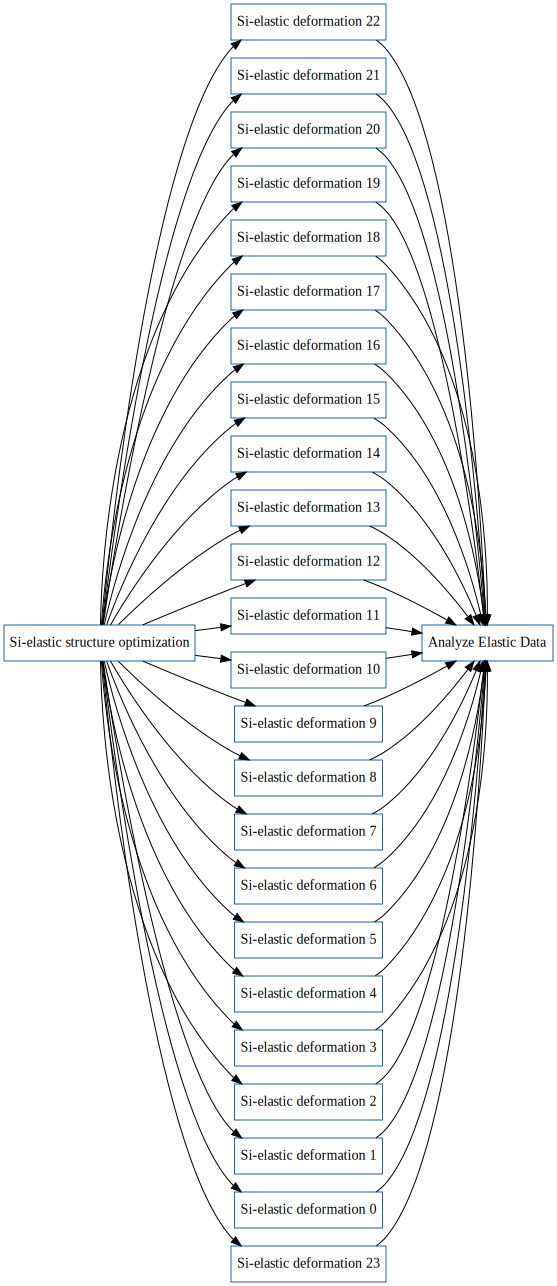

In [9]:
from mp_workshop.atomate import wf_to_graph
wf_to_graph(wf)

From our exploration of the workflow, we can see that the workflow has a "root" firework, which is the structure optimization firework, and a single "leaf" firework, which is the analysis task.  In between, we have several fireworks which have "elastic deformation" in their titles, each of which represents a calculation which will transform the output of the optimization firework by applying a unique strain.

In the analysis step, the stresses from those deformations and the strains are aggregated and used to fit an elastic tensor.  Let's examine the different types of fireworks using the graph tool.

Si-elastic deformation 22


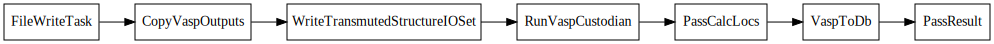

In [10]:
print(wf.fws[0].name)
wf_to_graph(wf.fws[0])

Si-elastic deformation 21


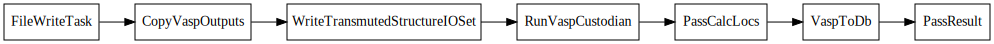

In [11]:
print(wf.fws[1].name)
wf_to_graph(wf.fws[1])

Si-elastic deformation 23


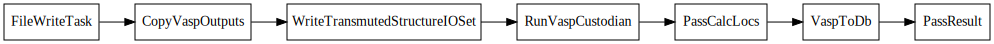

In [12]:
print(wf.fws[-1].name)
wf_to_graph(wf.fws[-1])

Note that the standard preset workflow for the elastic tensor uses many calculations in excess of what is required to determine the elastic tensor, which yields a higher-quality tensor in which some of the numerical noise is washed out over the duplicity of calculations.  Note that you can also generate a "minimal" elastic workflow which uses neither the more expensive DFT parameters nor the extended calculations.  Tensors generated using this workflow are typically not as accurate, but often work for simple semiconductors with a lot of symmetry.  Let's try it with bulk silicon.

In [13]:
wf = wf_elastic_constant_minimal(structure)

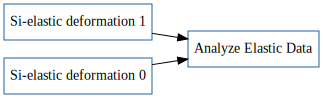

In [14]:
wf_to_graph(wf)

Note that for silicon, the two deformation tasks are a single normal deformation along the x axis (which are equivalent to those along the y- and z-axis), and a single shear deformation (equivalent to the two others normally included).  Since this is considerably simpler, we'll run this as our example.

To run the workflow, we import our launchpad and rocket launcher tools.  Since we can't use VASP in the workflow, we're also going to "fake" vasp by copying files rather than running the binary.

In [15]:
from fireworks import LaunchPad
from mp_workshop.atomate import use_fake_vasp_workshop

In [16]:
wf.name

'Si:elastic constants'

In [17]:
wf = use_fake_vasp_workshop(wf)
lpad.add_wf(wf)

2018-08-10 05:47:27,561 INFO Added a workflow. id_map: {-1157: 1, -1156: 2, -1155: 3}


{-1157: 1, -1156: 2, -1155: 3}

Now we can run the workflow either in the notebook using the pythonic fireworks rocket launcher or using `qlaunch` from the linux command line.

In [18]:
from fireworks.core.rocket_launcher import rapidfire

In [19]:
import os

In [20]:
os.chdir("temp")
rapidfire(lpad)

2018-08-10 05:47:27,784 INFO Created new dir /home/jovyan/work/workshop-2018/lessons/atomate/temp/launcher_2018-08-10-05-47-27-784616
2018-08-10 05:47:27,785 INFO Launching Rocket
2018-08-10 05:47:27,847 INFO RUNNING fw_id: 3 in directory: /home/jovyan/work/workshop-2018/lessons/atomate/temp/launcher_2018-08-10-05-47-27-784616
2018-08-10 05:47:27,878 INFO Task started: FileWriteTask.
2018-08-10 05:47:27,879 INFO Task completed: FileWriteTask 
2018-08-10 05:47:27,884 INFO Task started: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}}.
2018-08-10 05:47:27,933 INFO Task completed: {{atomate.vasp.firetasks.write_inputs.WriteTransmutedStructureIOSet}} 
2018-08-10 05:47:27,939 INFO Task started: {{atomate.vasp.firetasks.run_calc.RunVaspFake}}.
2018-08-10 05:47:27,975 INFO atomate.vasp.firetasks.run_calc RunVaspFake: verified inputs successfully
2018-08-10 05:47:28,011 INFO atomate.vasp.firetasks.run_calc RunVaspFake: ran fake VASP, generated outputs
2018-08-10 05:47:28,0

/opt/conda/lib/python3.5/site-packages/pymatgen/analysis/elasticity/elastic.py:916: UserWarning: No eq state found, returning zero voigt stress
  warnings.warn("No eq state found, returning zero voigt stress")


2018-08-10 05:47:32,135 INFO Rocket finished


Traceback (most recent call last):
  File "/home/jovyan/src/fireworks/fireworks/core/rocket.py", line 262, in run
    m_action = t.run_task(my_spec)
  File "/opt/conda/lib/python3.5/site-packages/atomate/vasp/firetasks/parse_outputs.py", line 363, in run_task
    d.update({"derived_properties": ieee.get_structure_property_dict(ref_struct)})
  File "/opt/conda/lib/python3.5/site-packages/pymatgen/analysis/elasticity/elastic.py", line 440, in get_structure_property_dict
    sp_dict = {prop: getattr(self, prop)(structure) for prop in s_props}
  File "/opt/conda/lib/python3.5/site-packages/pymatgen/analysis/elasticity/elastic.py", line 440, in <dictcomp>
    sp_dict = {prop: getattr(self, prop)(structure) for prop in s_props}
  File "/opt/conda/lib/python3.5/site-packages/pymatgen/analysis/elasticity/elastic.py", line 106, in wrapper
    raise ValueError("Bulk or shear modulus is negative, property "
ValueError: Bulk or shear modulus is negative, property cannot be determined


## Powerups

Atomate contains a number of tools for modifying workflows, known as "powerups" which are functions which will modify the workflows in commonly desired ways.  For example, if you want to modify the parameters of a VASP calculation, you can use the add_modify_incar powerup to change these for every firework in the workflow.

### add_modify_incar

In [21]:
from atomate.vasp.powerups import add_modify_incar

In [22]:
wf = get_wf(structure, "bandstructure.yaml")

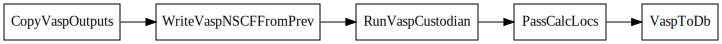

In [23]:
wf_to_graph(wf.fws[0])

In [24]:
modified = add_modify_incar(wf, {"incar_update": {"ENCUT": 700}})

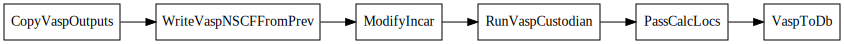

In [25]:
wf_to_graph(modified.fws[0])

Prior to the execution of the VASP calculation, a ModifyIncar firetask is inserted which will read the incar and modify the ENCUT parameter such that it matches our powerup specification.

### add_tags, add_structure_metadata

In [26]:
from atomate.vasp.powerups import add_tags

In [27]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'additional_fields': {'task_label': 'nscf uniform'}, 'parse_dos': True, 'bandstructure_mode': 'uniform', 'db_file': None}


In [28]:
wf = add_tags(wf, ["photocathodes"])

In [29]:
print("WF metadata: ", wf.metadata)
print("Last task: ", wf.fws[0].tasks[-1])

WF metadata:  {'tags': ['photocathodes']}
Last task:  <{{atomate.vasp.firetasks.parse_outputs.VaspToDb}}>:{'additional_fields': {'task_label': 'nscf uniform', 'tags': ['photocathodes']}, 'parse_dos': True, 'bandstructure_mode': 'uniform', 'db_file': None}


## A few other "complex" workflows.

Atomate contains a few workflows that will do more complicating things like calculations on surfaces.  Let's say I want to calculate the determine the hydrogen adsorption energy on every low-index facet of Pt.

In [30]:
from atomate.vasp.workflows.base.adsorption import get_wf_surface_all_slabs
from pymatgen import MPRester, Molecule

In [31]:
pt = mpr.get_structure_by_material_id("Pt", conventional_unit_cell=True)
adsorbate = Molecule("H", [[0, 0, 0]])

In [32]:
wf = get_wf_surface_all_slabs(pt, [adsorbate])

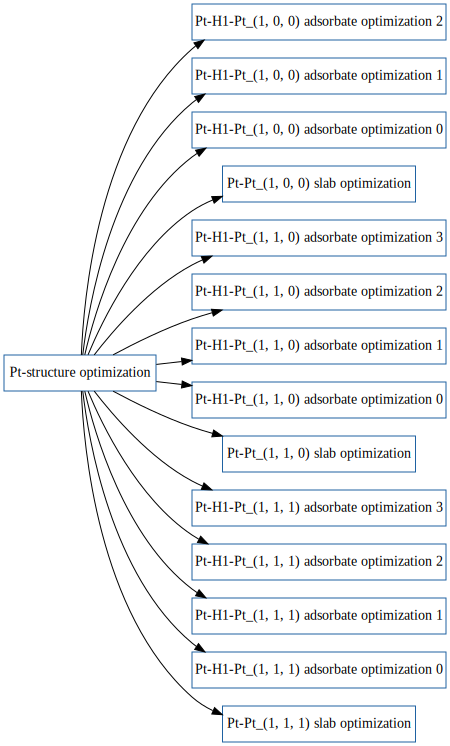

In [33]:
wf_to_graph(wf)

This is how you can do the requisite calculation to find the band-gap from an HSE calculation after the PBE bandstructure.

In [34]:
from atomate.vasp.workflows.presets.core import wf_bandstructure_plus_hse

In [35]:
wf = wf_bandstructure_plus_hse(structure)

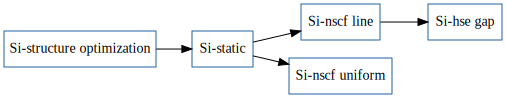

In [36]:
wf_to_graph(wf)

There's also support for workflows in FEFF and QChem.

In [37]:
from atomate.feff.workflows.core import get_wf_xas

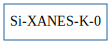

In [38]:
wf = get_wf_xas("Si", structure)
wf_to_graph(wf)

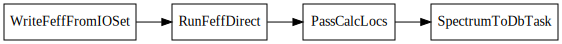

In [39]:
wf_to_graph(wf.fws[0])

In [40]:
#from atomate.qchem.workflows.base.double_FF_opt import get_wf_double_FF_opt
#from pymatgen import Molecule
#molecule = Molecule("CO", [[0, 0, 0], [0, 0, 1.23]])
#wf = get_wf_double_FF_opt(molecule, 0.5)
#wf_to_graph(wf)
#wf_to_graph(wf.fws[0])

## Analyzing workflow results

Our final example for atomate will take a set of tasks from our database and construct a phase diagram.

In [41]:
structures = mpr.get_structures("Al-Cr")
structures += mpr.get_structures("Al")
structures += mpr.get_structures("Cr")
for structure in structures:
    wf = get_wf(structure, "bandstructure.yaml")
    lpad.add_wf(wf)

2018-08-10 05:47:35,290 INFO Added a workflow. id_map: {-1184: 6, -1183: 7, -1186: 4, -1185: 5}
2018-08-10 05:47:35,308 INFO Added a workflow. id_map: {-1190: 8, -1189: 9, -1188: 10, -1187: 11}
2018-08-10 05:47:35,323 INFO Added a workflow. id_map: {-1192: 14, -1191: 15, -1194: 12, -1193: 13}
2018-08-10 05:47:35,348 INFO Added a workflow. id_map: {-1198: 16, -1197: 17, -1196: 18, -1195: 19}
2018-08-10 05:47:35,355 INFO Added a workflow. id_map: {-1200: 22, -1199: 23, -1202: 20, -1201: 21}
2018-08-10 05:47:35,363 INFO Added a workflow. id_map: {-1206: 24, -1205: 25, -1204: 26, -1203: 27}
2018-08-10 05:47:35,370 INFO Added a workflow. id_map: {-1208: 30, -1207: 31, -1210: 28, -1209: 29}
2018-08-10 05:47:35,378 INFO Added a workflow. id_map: {-1214: 32, -1213: 33, -1212: 34, -1211: 35}
2018-08-10 05:47:35,385 INFO Added a workflow. id_map: {-1216: 38, -1215: 39, -1218: 36, -1217: 37}
2018-08-10 05:47:35,392 INFO Added a workflow. id_map: {-1222: 40, -1221: 41, -1220: 42, -1219: 43}
2018-0

In [42]:
from maggma.stores import MongoStore

In [43]:
tasks = MongoStore(database="vasp_db", collection_name="tasks")

In [44]:
tasks.connect()

In [45]:
doc = tasks.query_one(criteria={"chemsys": "Al"})

In [46]:
doc.keys()

dict_keys(['custodian', 'calcs_reversed', 'formula_reduced_abc', 'composition_unit_cell', 'task_label', 'dir_name', 'task_id', 'analysis', 'output', 'formula_anonymous', 'transformations', 'task_type', 'elements', 'orig_inputs', 'last_updated', 'completed_at', 'composition_reduced', 'schema', 'nsites', 'chemsys', 'state', '_id', 'formula_pretty', 'run_stats', 'nelements', 'input'])

In [47]:
doc['chemsys']

'Al'

In [48]:
doc = tasks.query_one(criteria={"chemsys": "Al"}, properties=['output'])

In [49]:
docs = tasks.query(criteria={"chemsys": "Al-Cr", 
                             "task_label": "structure optimization"},
                   properties=['output', 'formula_pretty'])
docs

In [50]:
docs = list(docs)

In [51]:
[d['formula_pretty'] for d in docs]

['AlCr2', 'Al8Cr5', 'Al45Cr7', 'Al3Cr']

In [52]:
fe_cr_tasks = []
for chemsys in ['Al', 'Cr', 'Al-Cr']:
    task_list = tasks.query(criteria={"chemsys": chemsys,
                                      "task_label": "structure optimization"},
                            properties=["output", "composition_unit_cell"])
    fe_cr_tasks.extend(list(task_list))

In [53]:
len(fe_cr_tasks)

16

In [54]:
from pymatgen.entries.computed_entries import ComputedEntry
from pymatgen import Composition

In [55]:
entries = []
for task in fe_cr_tasks:
    energy = task['output']['energy']
    composition = Composition.from_dict(task['composition_unit_cell'])
    entry = ComputedEntry(composition, energy)
    entries.append(entry)

In [56]:
from pymatgen.analysis.phase_diagram import PhaseDiagram, PDPlotter

In [57]:
pd = PhaseDiagram(entries)

In [58]:
plotter = PDPlotter(pd)

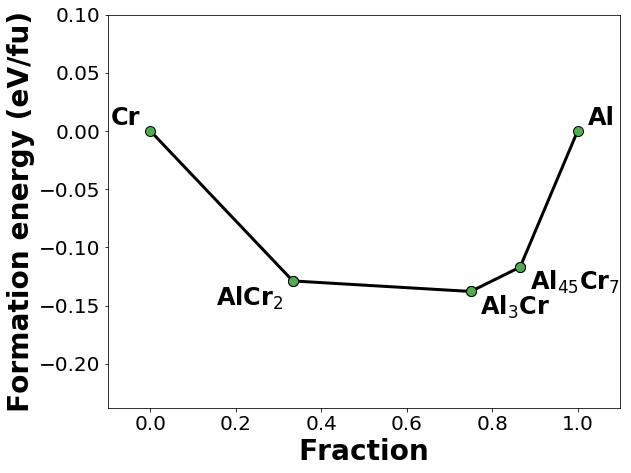

In [59]:
plotter.show()

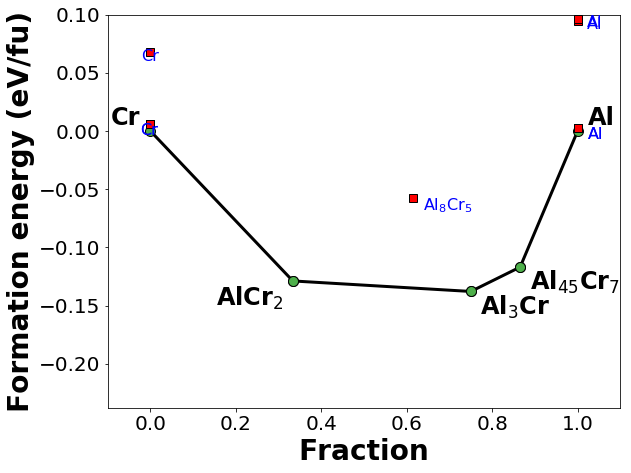

In [60]:
plotter.show_unstable = True
plotter.show()